In [47]:
from collections import namedtuple
from enum import Enum

from PIL import Image

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import random
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display
from tqdm import tqdm

import cv2
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torch.optim as optim

# Practica 2
Prats Guasch, Víctor Antonio

## 1. Problema a resoldre
En aquesta segona pràctica es demana crear un xarxa neuronal capaç de discriminar entre gossos i gats. La xarxa desenvolupada s'ha de comparar amb una xarxa ja existent, reentrenada amb el dataset donat. S'ha dedicit implementar també la classificació de les races de les diferents mascotes, a partir de una xarxa estandaritzada.

TODO: Enumerar punts a seguir i estrategia general

## 2. Anàlisi del conjunt de dades
El conjunt de dades proporcionat conté un fitxer anomenat `list.txt` que enumera totes les imatges del dataset, juntament amb seu identificador de "clase" (o raça en el nostre contexte) i la espècie (1: Gat o 2: Gos). Per a treballar amb el dataset, llegirem primer aquest fitxer i crearem un conjunt de entrenament i de test a partir de les imatges enumerades, lo que ens permetrà determinar la categoria objectiu a partir de cadascuna de línies llegides.

In [12]:
class AugmentationStrategy(Enum):
    NONE = 0
    ROTATE_RIGHT = 1
    ROTATE_LEFT = 2

# Cream les clases que representen cada tupla de elements (image_path, label, augmentation, args)
DataPoint = namedtuple("DataPoint", ["image_path", "label", "augmentation", "arg0"])

dataset_base_path = "../../PetDataset/"

def split_train_test(lines, train_percentage = 0.5):
    random_indices = random.sample(range(len(lines)), int(len(lines) * train_percentage))
    
    random_subset = [lines[i] for i in random_indices]
    remaining_elements = [elem for idx, elem in enumerate(lines) if idx not in random_indices]
    
    return random_subset, remaining_elements

def data_augment_cats(data_points):
    new_data_points = [DataPoint(point.image_path, point.label, AugmentationStrategy.ROTATE_RIGHT, 5) 
                           for point in data_points if point.label == 0]
    return data_points + new_data_points

with open(f"{dataset_base_path}/annotations/list.txt") as f:
    all_data = []
    for line in f.readlines()[6:]:    
        line = line.strip().split(' ')
        
        image_path = line[0]
        # Take the species from the annotations, and substract 1 to treat it as a category
        label = int(line[2]) - 1
        all_data.append(DataPoint(image_path, label, AugmentationStrategy.NONE, None))

balanced_class_data = data_augment_cats(all_data)
train_data, test_data = split_train_test(balanced_class_data)

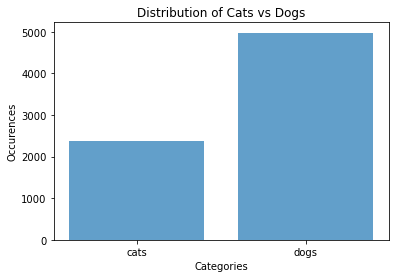

In [13]:
def count_cats_and_dogs(data_points) -> dict:
    result = {"cats": 0, "dogs": 0}

    for data_point in data_points:
        if data_point.label == 0:
            result["cats"] += 1
        else:
            result["dogs"] += 1
            
    return result

base_subset_counts = count_cats_and_dogs(all_data)

plt.bar(base_subset_counts.keys(), base_subset_counts.values(), align='center', alpha=0.7)
plt.title("Distribution of Cats vs Dogs")
plt.xlabel("Categories")
plt.ylabel("Occurences")
plt.show()

Tal i com es presenta, la nostra categoria objectiu no està balancejada. Per a solucionar aquest problema, s'han fet servir técniques de data augmentation, totes les imatges de gats seràn duplicades i rotades 5 graus en sentit horari. Aquesta mateixa implementació serà útil per provar el rendiment del model sobre més dades d'entrenament.

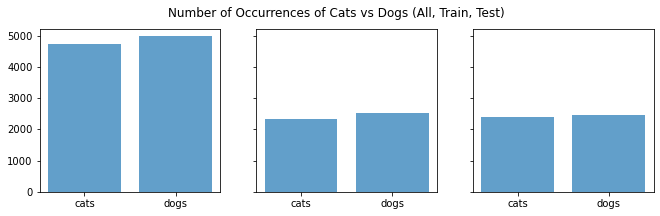

In [16]:
base_subset_counts_balanced = count_cats_and_dogs(balanced_class_data)
base_subset_counts_train = count_cats_and_dogs(train_data)
base_subset_counts_test = count_cats_and_dogs(test_data)

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)
axs[0].bar(base_subset_counts_balanced.keys(), base_subset_counts_balanced.values(), align='center', alpha=0.7)
axs[1].bar(base_subset_counts_train.keys(), base_subset_counts_train.values(), align='center', alpha=0.7)
axs[2].bar(base_subset_counts_test.keys(), base_subset_counts_test.values(), align='center', alpha=0.7)
fig.suptitle('Number of Occurrences of Cats vs Dogs (All, Train, Test)')
plt.show()

Com podem veure, els conjunts d'entrenament i de proves mantenen el mateix rati d'ocurrencies de gossos i gats. Podem ara preparar el dataset dividint cada linia per espais i triant la categoria que ens sigui rellevant com a label.

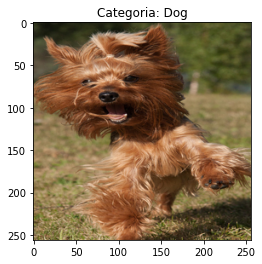

In [14]:
# Seleccionam una linia aleatoria d'entrenament i verificam l'extracció de l'espècie objectiu
species_dict = {0: "Cat", 1: "Dog"}

random.seed(33)
selected_data = train_data[random.randint(0, len(train_data))]

img = Image.open(f"{dataset_base_path}/images/{selected_data.image_path}.jpg")
img = img.convert("RGB")

plt.imshow(img.resize(size = (256, 256)))
plt.title(f"Categoria: {species_dict[selected_data.label]}")
plt.show()

In [27]:
class PetDataset(Dataset):
    def __init__(self, data_points, transform=None):
        super().__init__()
        self.data_points = data_points
        self.len = len(self.data_points)
        self.transform = transform

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        data_point = self.data_points[index]
        # TODO: Verificar que totes les images a list.txt siguen presents a /images/ i viceversa
        image = Image.open(f"{dataset_base_path}/images/{data_point.image_path}.jpg")
        image = image.convert("RGB")
        image = self.__apply_data_augmentation(image, data_point)
        
        label = data_point.label
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label
    
    def __apply_data_augmentation(self, image, data_point):
        # No hi ha match, python 3.9 :(
        if data_point.augmentation == AugmentationStrategy.NONE:
            return image
        elif data_point.augmentation == AugmentationStrategy.ROTATE_RIGHT:
            return image.rotate(abs(data_point.arg0))
        elif data_point.augmentation == AugmentationStrategy.ROTATE_LEFT:
            return image.rotate(-abs(data_point.arg0))
        else:
            raise NotImplementedError("Unhandled data augmentation technique")
    
mean = [0.4792, 0.4450, 0.3962]
std = [0.2293, 0.2262, 0.2271]
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((256, 256), antialias=True),
        transforms.Normalize(mean=mean, std=std),
    ]
)

train_ds = PetDataset(train_data, transform)
train_dl = DataLoader(train_ds, batch_size=64)
train_dl.dataset[0][0].shape, train_dl.dataset[0][1]

(torch.Size([3, 256, 256]), 1)

In [28]:
# WHY? https://stackoverflow.com/questions/4674623/why-do-we-have-to-normalize-the-input-for-an-artificial-neural-network/60820402#60820402
#https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer-learning/115670
mean, std = 0.0, 0.0
num_samples = len(train_ds)

for data, _ in tqdm(train_ds, total=num_samples):
    mean += data.mean(dim=(1, 2))
    std += data.std(dim=(1, 2))

mean /= num_samples
std /= num_samples

print("Mean:", mean)
print("Std:", std)

100%|█████████████████████████████████████████████████████████████████████████████| 4860/4860 [00:17<00:00, 279.02it/s]

Mean: tensor([-1.0518e-04,  2.0603e-04, -1.2460e-05])
Std: tensor([1.0000, 1.0002, 1.0000])


In [30]:
test_ds = PetDataset(test_data, transform)
test_dl = DataLoader(test_ds, batch_size=64)
test_dl.dataset[0][0].shape, test_dl.dataset[0][1]

(torch.Size([3, 256, 256]), 0)

Una vegada creats els datasets, es definirà una xarxa amb un arquictura similar a la VGG-16 però amb un nombre molt més reduït de capes convolucionals, ja que el problema es molt més reduït.

## Definició de la xarxa

In [38]:
class SmallVGG(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallVGG, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 64x64x64
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=1),
            #nn.Softmax(1)
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x).squeeze()
        return x

In [ ]:
class SmallVGG3Layers(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallVGG3Layers, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32x128
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1),
            #nn.LogSoftmax(1)
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x).squeeze()
        return x

In [27]:
class SmallVGG4Layers(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallVGG4Layers, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32x128
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 16x16x256
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1),
            #nn.LogSoftmax(1)
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x).squeeze()
        return x

In [54]:
class SmallVGGFC(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallVGGFC, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x32x128
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 32 * 128, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

In [8]:
class SmallVGGFCExtra(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallVGGFCExtra, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x32x128
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 16 * 256, 1024),
            nn.ReLU(),
            nn.Dropout(),
            #nn.Linear(1024, 1024),
            #nn.ReLU(),
            #nn.Dropout(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

In [33]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout2d(p=0.25)
        
        self.fc = nn.Linear(in_features=32 * 32 * 64, out_features=num_classes)

    def forward(self, x):
                                             # Inici: 256x256x3
        x = F.relu(self.pool(self.conv1(x))) # 128x128x16
        x = F.relu(self.pool(self.conv2(x))) # 64x64x32
        x = F.relu(self.pool(self.conv3(x))) # 32x32x32
        x = F.relu(self.drop(self.conv4(x))) # 32x32x64
        
        x = F.dropout(x, training=self.training)
        
        x = x.view(-1, 32 * 32 * 64)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [43]:
class SmallCNN6Layers(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallCNN6Layers, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout2d(p=0.25)
        
        self.fc = nn.Linear(in_features=8 * 8 * 128, out_features=num_classes)

    def forward(self, x):
                                             # Inici: 256x256x3
        x = F.relu(self.pool(self.conv1(x))) # 128x128x16
        x = F.relu(self.pool(self.conv2(x))) # 64x64x32
        x = F.relu(self.pool(self.conv3(x))) # 32x32x32
        x = F.relu(self.pool(self.conv4(x))) # 16x16x64
        x = F.relu(self.pool(self.conv5(x))) # 8x8x64
        x = F.relu(self.drop(self.conv6(x))) # 8x8x128

        
        x = F.dropout(x, training=self.training)
        
        x = x.view(-1, 8 * 8 * 128)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [46]:
class SmallCNN6LayersHidden(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallCNN6LayersHidden, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout2d(p=0.25)
        
        self.fc = nn.Linear(in_features=8 * 8 * 128, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
                                             # Inici: 256x256x3
        x = self.pool(F.relu(self.conv1(x))) # 128x128x16
        x = self.pool(F.relu(self.conv2(x))) # 64x64x32
        x = self.pool(F.relu(self.conv3(x))) # 32x32x32
        x = self.pool(F.relu(self.conv4(x))) # 16x16x64
        x = self.pool(F.relu(self.conv5(x))) # 8x8x64
        x = self.drop(F.relu(self.conv6(x))) # 8x8x128
        
        x = F.dropout(x, training=self.training)
        
        x = x.view(-1, 8 * 8 * 128)
        x = F.dropout(F.relu(self.fc(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [41]:
use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

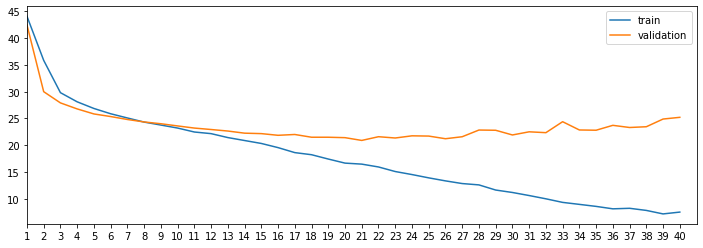

Epoch:40 Training Loss:7.541325098589847 Validation Loss:25.216266352556932: 100%|█████| 40/40 [24:22<00:00, 36.56s/it]


In [48]:
epochs = 40

model = SmallCNN6LayersHidden(num_classes=2).to(device)

optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(reduction="sum")
train_loader = train_dl
val_loader = test_dl

t_loss = np.zeros((epochs))
v_loss = np.zeros((epochs))

pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic

for epoch in pbar:
    
    train_loss = 0 
    val_loss = 0  
    
    model.train()                                                  
    for batch_num, (input_img, target) in enumerate(train_loader, 1):   
        input_img= input_img.to(device)
        target = target.to(device)
        
        output = model(input_img)
        
        loss = criterion(output, target)
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()     
        
        train_loss += loss.item()    
                                                       
    model.eval()   
    with torch.no_grad():                                          
        for input_img, target in val_loader: 
            input_img = input_img.to(device)
            target = target.to(device)
            
            output = model(input_img)                                   
            loss = criterion(output, target)   
            val_loss += loss.item()  
    
    # RESULTATS
    train_loss /= len(train_loader)
    t_loss[epoch-1] = train_loss
    
    val_loss /= len(val_loader)   
    v_loss[epoch-1] = val_loss
    
    # VISUALITZACIO DINAMICA
    plt.figure(figsize=(12, 4))
    pl.plot(t_loss[:epoch], label="train")
    pl.plot(v_loss[:epoch], label="validation")
    pl.legend()
    pl.xlim(0, epochs)
    pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.close()

    pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")

In [50]:
torch.save(model.state_dict(), "smallcnn6layershidden-40-epochs.pt")

## Evaluació

In [52]:
# Carregam el model desitjat

model = SmallCNN6LayersHidden(num_classes=2).to(device)
model.load_state_dict(torch.load("smallcnn6layershidden-40-epochs.pt"))

<All keys matched successfully>

In [53]:
model.eval() # Posam la xarxa en mode avaluació

targets = []
predictions = []

with torch.no_grad(): # desactiva el càlcul de gradients, no ho necessitam per l'inferència. Estalvia memòria i fa més ràpids els càlculs
    for data, target in test_dl:
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # index amb la max probabilitat
        targets.extend(target.tolist())
        predictions.extend(torch.flatten(pred.cpu()).tolist())
        
targets = np.asarray(targets)
predictions = np.asarray(predictions)

print(f"Accuracy: {accuracy_score(targets, predictions)}")

Accuracy: 0.8602880658436214


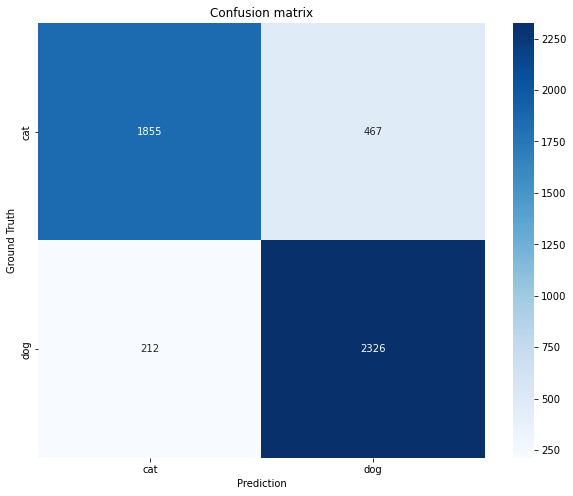

In [54]:
cm = confusion_matrix(targets, predictions)

classes = ["cat", "dog"]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Confusion matrix')
plt.show()

# Comparació de la xarxa desenvolupada amb AlexNet

In [26]:
alex_model = models.alexnet(weights=None)

# Reduim el nombre de neurones de manera gradual, ja que tenim 2 categories objectiu
alex_model.classifier[1] = nn.Linear(in_features=9216, out_features=2048)
alex_model.classifier[4] = nn.Linear(in_features=2048, out_features=1024)
alex_model.classifier[6] = nn.Linear(in_features=1024, out_features=2)
print(alex_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=2048, bias=True)
 

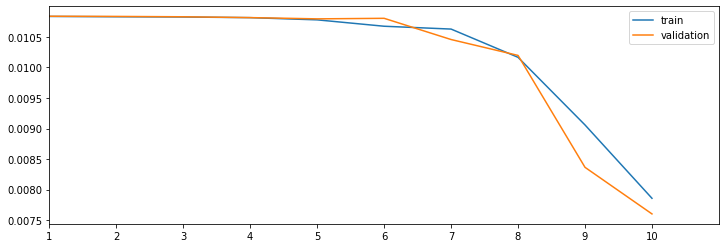

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:44<00:00, 34.41s/it]


In [29]:
# TODO: Reutilitzar funcions anteriors
train_loader = train_dl
test_loader = test_dl

def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in enumerate(train_loader):
    
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target, reduction='mean') 
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    #print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return loss_v


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='mean') 
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
  
    test_loss /= len(test_loader.dataset)

    #print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #    test_loss, correct, len(test_loader.dataset),
    #    100. * correct / len(test_loader.dataset)))
    
    return test_loss

use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

epochs = 10
lr = 1e-1

model = alex_model.to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # !!!

print("Parameters ", pytorch_total_params)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Guardam el valor de pèrdua mig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
for epoch in pbar:
    train_l[epoch-1] = train(model, device, train_loader, optimizer, epoch, verbose=False)
    test_l[epoch-1]  = test(model, device, test_loader)
    
    plt.figure(figsize=(12, 4))
    pl.plot(train_l[:epoch], label="train")
    pl.plot(test_l[:epoch], label="validation")
    pl.legend()
    pl.xlim(0, epochs)
    pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.close()

In [30]:
alex_model.eval() # Posam la xarxa en mode avaluació

targets = []
predictions = []

with torch.no_grad(): # desactiva el càlcul de gradients, no ho necessitam per l'inferència. Estalvia memòria i fa més ràpids els càlculs
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        output = alex_model(data)
        pred = output.argmax(dim=1, keepdim=True)  # index amb la max probabilitat
        targets.extend(target.tolist())
        predictions.extend(torch.flatten(pred.cpu()).tolist())
        
targets = np.asarray(targets)
predictions = np.asarray(predictions)

print(f"Accuracy: {accuracy_score(targets, predictions)}")

Accuracy: 0.7465020576131687


## I si fem servir els pesos de cataracteristiques preentrenats?

In [7]:
alex_model = models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1")

# Reduim el nombre de neurones de manera gradual, ja que tenim 2 categories objectiu
alex_model.classifier[1] = nn.Linear(in_features=9216, out_features=2048)
alex_model.classifier[4] = nn.Linear(in_features=2048, out_features=1024)
alex_model.classifier[6] = nn.Linear(in_features=1024, out_features=2)
print(alex_model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Victor/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|███████████████████████████████████████████████████████████████████████████████| 233M/233M [00:04<00:00, 53.3MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=2048, bias=True)
 

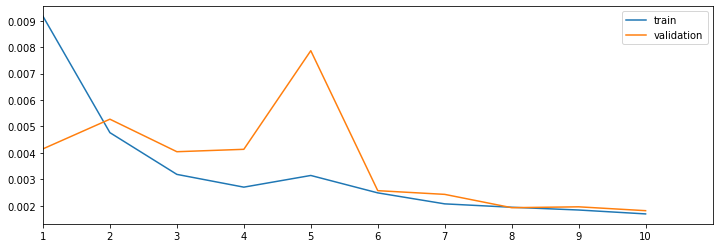

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:05<00:00, 36.55s/it]


In [8]:
for param in alex_model.features.parameters():
    param.requires_grad = False

# TODO: Reutilitzar funcions anteriors
train_loader = train_dl
test_loader = test_dl

def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in enumerate(train_loader):
    
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target, reduction='mean') 
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    #print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return loss_v


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='mean') 
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
  
    test_loss /= len(test_loader.dataset)

    #print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #    test_loss, correct, len(test_loader.dataset),
    #    100. * correct / len(test_loader.dataset)))
    
    return test_loss

use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

epochs = 10
lr = 1e-1

model = alex_model.to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # !!!

print("Parameters ", pytorch_total_params)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Guardam el valor de pèrdua mig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
for epoch in pbar:
    train_l[epoch-1] = train(model, device, train_loader, optimizer, epoch, verbose=False)
    test_l[epoch-1]  = test(model, device, test_loader)
    
    plt.figure(figsize=(12, 4))
    pl.plot(train_l[:epoch], label="train")
    pl.plot(test_l[:epoch], label="validation")
    pl.legend()
    pl.xlim(0, epochs)
    pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.close()

In [9]:
alex_model.eval() # Posam la xarxa en mode avaluació

targets = []
predictions = []

with torch.no_grad(): # desactiva el càlcul de gradients, no ho necessitam per l'inferència. Estalvia memòria i fa més ràpids els càlculs
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        output = alex_model(data)
        pred = output.argmax(dim=1, keepdim=True)  # index amb la max probabilitat
        targets.extend(target.tolist())
        predictions.extend(torch.flatten(pred.cpu()).tolist())
        
targets = np.asarray(targets)
predictions = np.asarray(predictions)

print(f"Accuracy: {accuracy_score(targets, predictions)}")

Accuracy: 0.9549382716049383


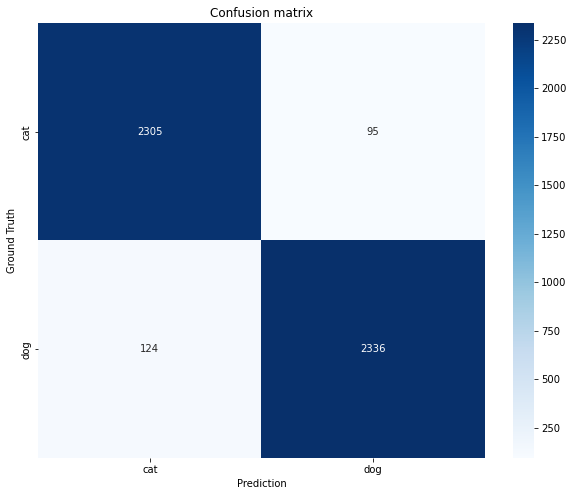

In [10]:
cm = confusion_matrix(targets, predictions)

classes = ["cat", "dog"]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Confusion matrix')
plt.show()